In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm

In [2]:
def outgoingRadiation(greenhouseCoefficient, temperature):
    '''
    how much energy is leaving our object.

    the higher the temperature is, the more energy is leaving.
    the lower temperature is, less energy leaves

    temperature leaving is modulated by greenhouse coeffecient. it tells us how much energy is kept on the planet due to greenhouse effect
    1 - greenhouseCoefficient tells us how much energy escapes despite greenhouse effect
    '''
    stefanBoltzmannConstant = 5.67e-8
    return (1 - greenhouseCoefficient) * stefanBoltzmannConstant * (temperature ** 4)

def rateOfTemperatureChange(energyComingIn, energyGoingOut, heatCapacity):
    '''
    heatCapacity is how much energy is required to change the temperature of an object.
    energyComingIn - energyGoingOut tells us the net change.

    if more energyIsLeaving, then according to the heatcapacity temp will be decreased by certain amount
    and vice versa
    '''
    return (energyComingIn - energyGoingOut) / heatCapacity

def temperatureChangeEulersMethod(temperatureOld, rateOfTemperatureChange, timeStep):
    '''
    update temperature based on rateOfTemperatureChange and timeStep added to old temp
    '''
    return temperatureOld + (rateOfTemperatureChange * timeStep)

In [16]:
def variableIncomingSolarRadiation(maxRadiation, timestep, timestepsInDay, latitudeBands):
    '''
    simulate day/night cycle to determine incoming solar energy.
    use 1st cos to vary amount of incoming solar energy scaled on maxRadiation (noon)
    use max(0, cos(...)) so when cos is negative, the incoming solar radiation is 0 not negative since negative solar energy doesnt make sense
    2nd cos to vary solar radiation based on latitude
    '''
    return maxRadiation * max(0, math.cos((2 * math.pi * timestep) / timestepsInDay)) * np.maximum(0, np.cos(np.radians(latitudeBands)))

In [4]:
def heatDiffusionBetweenLatitudes(temperatures, diffusionConstant, timestep):
    '''
    heat is transferred between latitudes based on the latitude above and below
    D(T_i+1​−T_i​)+D(T_i−1​−T_i​) where T_i represents temperature at latitude i and D diffusion constant
    rearranges to D * (T_i+1 - 2Ti + T_i-1 )
    this represents that temperature is gained/lost based on surrounding latitudes. if both T_i+1 and T_i-1 are very big then this will be positive and mean lots of temperature increase
    if T_i is big and T_i+1 and T_i-1 are small then this will be negative and mean lots of temperature decrease

    this is scaled based on diffusionConstant and the number of timesteps

    to be clear this is not the new temperature but based on the difference between latitudes, how much the temperature will change
    '''
    return diffusionConstant * (np.roll(temperatures, -1) - 2 * temperatures + np.roll(temperatures, 1)) * timestep

In [5]:
totalTimesteps = 10_000
startingTemperature = 250
heatCapacity = 1e7
timestepSeconds = 60 # seconds
timestepSecondsForDay = 86400
# incomingSolarRadiation = 240
maxIncomingSolarRadiation = 900
numLatitudes = 18+1
latitudeBands = np.linspace(90, -90, numLatitudes)

greenhouseCoefficient = 0.3
diffusionConstant = 0.1

In [24]:
temperatures = []
currentTemperature = np.array([startingTemperature for _ in range(numLatitudes)])
# incomingSolarEnergy = []
for t in range(0, totalTimesteps*timestepSeconds, timestepSeconds):
    outgoingEnergy = outgoingRadiation(greenhouseCoefficient, currentTemperature)

    incomingSolarRadiation = variableIncomingSolarRadiation(maxIncomingSolarRadiation, t, timestepSecondsForDay, latitudeBands)
    # incomingSolarEnergy.append(incomingSolarRadiation)
    rateOfTempChange = rateOfTemperatureChange(incomingSolarRadiation, outgoingEnergy, heatCapacity)
    currentTemperatures = temperatureChangeEulersMethod(currentTemperature, rateOfTempChange, timestepSeconds)
    print(currentTemperatures)
    heatDiffusion = heatDiffusionBetweenLatitudes(currentTemperatures, diffusionConstant, timestepSeconds)
    currentTemperatures += heatDiffusion
    print(heatDiffusion)
    print(currentTemperatures)

    temperatures.append(currentTemperatures)

Streaming output truncated to the last 5000 lines.
 249.99906977 249.99906977 249.99906977 249.99906977]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977]
[249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977 249.99906977
 249.99906977 249.99906977 249.99906977 249.99906977]
[249.99906977 249.999

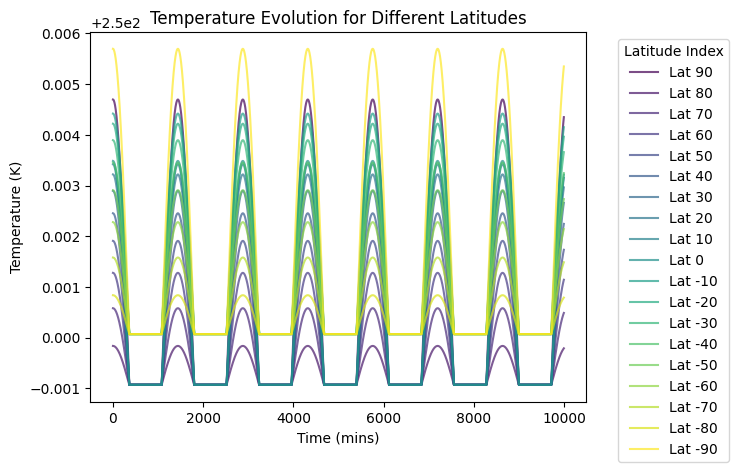

In [26]:
fig, ax1 = plt.subplots()
npTemperatures = np.array(temperatures)

colors = cm.viridis(np.linspace(0, 1, npTemperatures.shape[1]))
nudge=0 # currently symmetric latitudes have the exact same temp, they overlap on plot, doing this allows them to separate out
for lat_idx in range(npTemperatures.shape[1]):  # plot line for each lat
    if lat_idx > 9:
        nudge = 0.001
    ax1.plot(np.arange(totalTimesteps), npTemperatures[:, lat_idx]+nudge, label=f"Lat {int(latitudeBands[lat_idx])}", color=colors[lat_idx], alpha=0.7)

ax1.set_xlabel("Time (mins)")
ax1.set_ylabel("Temperature (K)")
ax1.set_title("Temperature Evolution for Different Latitudes")

# Add legend (but only if there aren't too many lines)
ax1.legend(title="Latitude Index", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()